# Pneumonia detection based on Chest X-Ray images on imbalanced data using tensorflow transformation

The original notebook can be found here https://www.kaggle.com/michalbrezk/x-ray-pneumonia-cnn-tensorflow-2-0-keras-94

## Introduction

In this notebook we use tensorflow to load and pre-process X-Ray images of chest and apply Keras CNN model on these data. Dataset is imbalanced (approx. 1:3), images may have different site and can have one or 3 color channels.



## Load libraries

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical


## Load Data

The dataset consists of 3 folders - train, test, val. Train & test are used for modeling, validation will be used to check performance of model. Size of validation set is very small (16 cases).

Each folder contains PNEUMONIA and NORMAL sub-folder. 

In [2]:
path='../chest_xray/'

val_dir = path+'val'
test_dir = path+'test'
train_dir = path+'train'

img_height = 196
img_width = 196
image_size =(img_height, img_width)

class_name = {"0":"NORMAL","1":"PNEUMONIA"}

batch_size = 32


### Load files

In [3]:
print("---------------train files-----------------")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='binary',class_names=["NORMAL","PNEUMONIA"], color_mode='grayscale',
    batch_size=batch_size, image_size=image_size, shuffle=True, seed=0, validation_split=None, subset=None)

print("---------------test files-----------------")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='binary',class_names=["NORMAL","PNEUMONIA"], color_mode='grayscale',
    batch_size=batch_size, image_size=image_size, shuffle=True, seed=0, validation_split=None, subset=None)

print("---------------validation files-----------------")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='binary',class_names=["NORMAL","PNEUMONIA"], color_mode='grayscale',
    batch_size=batch_size, image_size=image_size, shuffle=True, seed=0, validation_split=None, subset=None)

---------------train files-----------------
Found 5216 files belonging to 2 classes.
---------------test files-----------------
Found 624 files belonging to 2 classes.
---------------validation files-----------------
Found 16 files belonging to 2 classes.


In [6]:
for image_batch, labels_batch in train_data:
    print("batch image shape: ")
    print(image_batch.shape)
    print("batch label shape: ")
    print(labels_batch.shape)
    break

batch image shape: 
(32, 196, 196, 1)
batch label shape: 
(32, 1)


### display some image

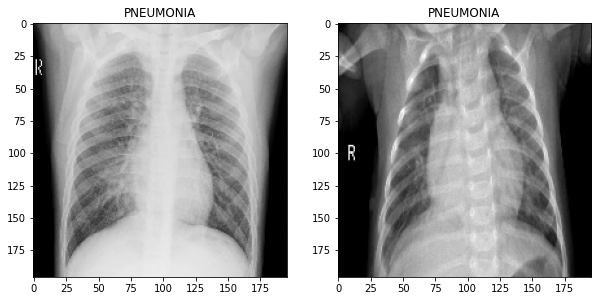

In [18]:
import matplotlib.pyplot as plt

class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[int(labels[i])])
        #plt.axis("off")

## Pre-processing

### Standardization


In [19]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

test = test_data.map(lambda x, y: (normalization_layer(x), y))
val = val_data.map(lambda x, y: (normalization_layer(x), y))

0.0 0.9858293


### Data augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1)

])

train_ds = train.map(lambda x, y: (data_augmentation(x), y))


"""
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)
"""

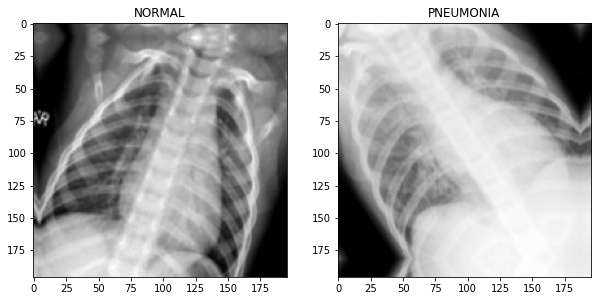

In [21]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[int(labels[i])])
        #plt.axis("off")

### Convert to numpy

In [22]:
Y_train = np.concatenate([y for x , y in train_ds], axis=0)
X_train = np.concatenate([x for x , y in train_ds], axis=0)

Y_test = np.concatenate([y for x , y in test], axis=0)
X_test = np.concatenate([x for x , y in test], axis=0)

Y_val = np.concatenate([y for x , y in val], axis=0)
X_val = np.concatenate([x for x , y in val], axis=0)

In [23]:
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, Y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, Y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, Y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216, 1)
Test data shape: (624, 196, 196, 1), Labels shape: (624, 1)
Validation data shape: (16, 196, 196, 1), Labels shape: (16, 1)


In [24]:
Y_train = Y_train.squeeze()
Y_test = Y_test.squeeze()
Y_val = Y_val.squeeze()

In [25]:
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, Y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, Y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, Y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [26]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)
y_val = to_categorical(Y_val)

## Modeling

### define model

In [27]:


model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [13]:

saveBestModel = keras.callbacks.ModelCheckpoint('../models/pneu_detect_cnn-keras_model.hdf5', 
                                                monitor='val_acc', verbose=0, 
                                                save_best_only=True, 
                                                save_weights_only=False, 
                                                mode='auto')

callback = EarlyStopping(monitor='loss', patience=2)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 2, verbose = 1,
                    callbacks=[saveBestModel,callback], class_weight={0:6.0, 1:0.5})


Epoch 1/2
1304/1304 [==============================] - 528s 404ms/step - loss: 1.0152 - accuracy: 0.2830 - val_loss: 1.0524 - val_accuracy: 0.3750
Epoch 2/2
1304/1304 [==============================] - 537s 412ms/step - loss: 0.9483 - accuracy: 0.2525 - val_loss: 1.1276 - val_accuracy: 0.3750
